# Reinforcement Learning - Assignment 2 - Jack Murray

### Setup Steps

#### Load Packages

In [253]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {"figure.figsize":(10, 6)})

#### Create a class representing the environment

In [254]:
class Segment: #(gym.Env):
    def __init__(self,numActions,startObservation,p,terminal,done):
        self.numActions = numActions
        self.observation = startObservation
        self.p = p
        self.terminal = terminal
        self.action_space = spaces.Discrete(self.numActions) # {0:left, 1:right}
        self.observation_space = spaces.Discrete(2*self.terminal+1)
        self.done = done
    def step(self,action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.observation)
        assert self.action_space.n == 2
        assert self.observation!=0
        assert self.observation!=(2*self.terminal)
        observation = self.observation
        done = self.done
        if action==0:
            observation_next = observation + np.random.choice([-1,1],p=[self.p,1-self.p])
        elif action==1:
            observation_next = observation + np.random.choice([-1,1],p=[1-self.p,self.p])
        if observation_next == (2*self.terminal):
            done = True
        elif observation_next == 0:
            done = True
        self.done = done
        self.observation = observation_next
        reward=self.rewards(observation,observation_next,action)
        return [self.observation,reward,done]
    def rewards(self,observation,observation_next,action):
        if observation_next==(2*self.terminal):
            reward = 1.0
        elif observation_next==0:
            reward = -1.0
        else:
            reward = -0.05
        return reward
    def reset(self):
        observation = self.startObservation
        self.observation = observation
        self.done = False
        return observation

## Part 1 - Always try to go Right

### Question 1

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either terminal of the path (0 or 20), the episode ends and the robot doesn't make any more moves. For every other space, the robot has an 80% chance of moving right, and a 20% chance of moving left.

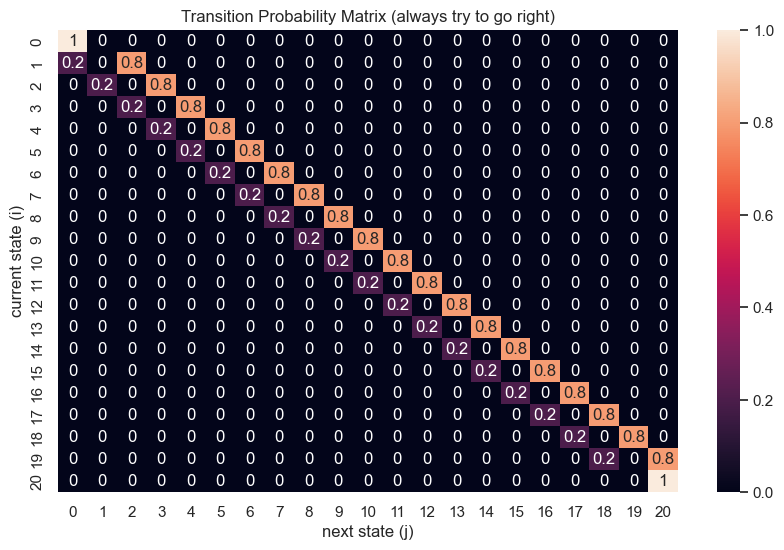

In [255]:
P = np.zeros((21, 21))
P = pd.DataFrame(P)

for s in range(21):
    if s == 0 or s == 20:
        P.iloc[s, s] = 1.0
    else:
        P.iloc[s, s+1] = 0.8 # 80% chance of moving right as intended
        P.iloc[s, s-1] = 0.2 # 20% chance of moving left
        
sns.set(rc = {"figure.figsize":(10, 6)})
mtx = sns.heatmap(P, annot = True)
mtx.set(xlabel = 'next state (j)',
        ylabel = 'current state (i)',
        title = 'Transition Probability Matrix (always try to go right)');

### Question 2

In [256]:
print('Classes are as follows:')
print('{ 0 }') # 0 is an absorbing state and thus forms its own class

class_list = []
for s in range(1, 19):
    class_item = (s, s+1)
    class_list.append(class_item) # collect the classes in a list so we can count them at the end
    print('{', s, ',', s+1,'}') # other than 0 and 20, every other state forms a class with its neighboring states
    
print('{ 20 }') # 20 is an absorbing state and thus forms its own class

# remember to include the two classes for the absorbing states
class_list.append(0)
class_list.append(20)

print('\n')
print('There are', len(class_list), 'classes')

Classes are as follows:
{ 0 }
{ 1 , 2 }
{ 2 , 3 }
{ 3 , 4 }
{ 4 , 5 }
{ 5 , 6 }
{ 6 , 7 }
{ 7 , 8 }
{ 8 , 9 }
{ 9 , 10 }
{ 10 , 11 }
{ 11 , 12 }
{ 12 , 13 }
{ 13 , 14 }
{ 14 , 15 }
{ 15 , 16 }
{ 16 , 17 }
{ 17 , 18 }
{ 18 , 19 }
{ 20 }


There are 20 classes


The two terminal states (0 and 20) form their own classes. State 0 can be accessed by state 1, but not the other way around, so these states do not communicate and therefore state 0 forms its own class. The same logic can be applied to states 19 and 20 - 20 can be accessed by 19, but not the other way around, so state 20 forms its own class.

Other than 0 and 20, every other state can be accessed only by its two direct neighbors (except for 1 and 19 which can only be accessed by their non-terminal neighboring state). This logic forms the classes listed above.

### Question 3

#### Write the policy - always try to move right

In [257]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists. Construct a loop to go through up to 1000 steps (unless absorbing state is reached first). Plot the steps.

p = 0.8, meaning that the robot's action will result in moving right 80% of the time, and left the other 20% of the time

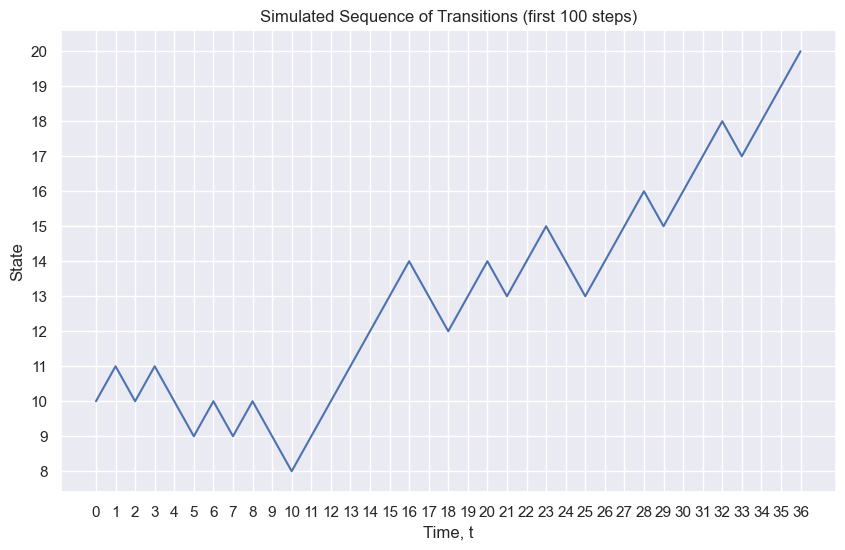

In [258]:
t=0
tMAX = 1000 # representing a simulation of up to 1000 steps
done = False
observation = 10
observations = [observation]
rewards = []
actions = []
t_log = [t]

env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t_log.append(t+1)
    t+=1

plt.plot(t_log[0:101], observations[0:101]) # only plot the first 100 steps
plt.xticks(np.arange(np.min(t_log[0:101]), np.max(t_log[0:101])+1, 1))
plt.yticks(np.arange(np.min(observations[0:101]), np.max(observations[0:101])+1, 1))
plt.xlabel('Time, t')
plt.ylabel('State')
plt.title('Simulated Sequence of Transitions (first 100 steps)')
plt.show();

#### Report the likelihood of the first 100 steps.

The code below will compute the state probabilities for steps 1 through 100. We can use the method that we learned in class below:

$$
p(n) = p(0)\cdot P(n)p(n) = p\cdot P(n)
$$

In [259]:
Pmat = np.array(P, dtype = float)
p0 = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.2, 0., 0.8, 0., 0., 0., 0., 0., 0., 0., 0., 0.]

T = 100 # we want to look at the first 100 steps
n = 21 # representing the 21 states in our environment
P_new = np.zeros((T,n,n),dtype=np.float64)
p1= np.zeros((T,1,n),dtype=np.float64)

P_new[0] = Pmat
p1[0] = p0

for t in range(1,T):
    # method 1: p(n) = p(0) * P(n)
    p1[t] = np.matmul(p0,P_new[t-1])
    # update n-step transition matrix
    P_new[t] = np.matmul(P_new[t-1],Pmat)

new_array = p1.reshape((100, 21))
df = pd.DataFrame(new_array)
df.index = list(range(1, 101))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print('Likelihood of each transition at each step (assuming we start at state 10):')
df

Likelihood of each transition at each step (assuming we start at state 10):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,0.000000e+00,8.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e-02,0.000000e+00,3.200000e-01,0.000000e+00,6.400000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e-03,0.000000e+00,9.600000e-02,0.000000e+00,3.840000e-01,0.000000e+00,5.120000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e-03,0.000000e+00,2.560000e-02,0.000000e+00,1.536000e-01,0.000000e+00,4.096000e-01,0.000000e+00,4.096000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e-04,0.000000e+00,6.400000e-03,0.000000e+00,5.120000e-02,0.000000e+00,2.048000e-01,0.000000e+00,4.096000e-01,0.000000e+00,3.276800e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e-05,0.000000e+00,1.536000e-03,0.000000e+00,1.536000e-02,0.000000e+00,8.192000e-02,0.000000e+00,2.457600e-01,0.000000e+00,3.932160e-01,0.000000e+00,2.621440e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.000000e+00,0.000000e+00,0.000000e+00,1.280000e-05,0.000000e+00,3.584000e-04,0.000000e+00,4.300800e-03,0.000000e+00,2.867200e-02,0.000000e+00,1.146880e-01,0.000000e+00,2.752512e-01,0.000000e+00,3.670016e-01,0.000000e+00,2.097152e-01,0.000000e+00,0.000000e+00,0.000000
8,0.000000e+00,0.000000e+00,2.560000e-06,0.000000e+00,8.192000e-05,0.000000e+00,1.146880e-03,0.000000e+00,9.175040e-03,0.000000e+00,4.587520e-02,0.000000e+00,1.468006e-01,0.000000e+00,2.936013e-01,0.000000e+00,3.355443e-01,0.000000e+00,1.677722e-01,0.000000e+00,0.000000
9,0.000000e+00,5.120000e-07,0.000000e+00,1.843200e-05,0.000000e+00,2.949120e-04,0.000000e+00,2.752512e-03,0.000000e+00,1.651507e-02,0.000000e+00,6.606029e-02,0.000000e+00,1.761608e-01,0.000000e+00,3.019899e-01,0.000000e+00,3.019899e-01,0.000000e+00,1.342177e-01,0.000000
10,1.024000e-07,0.000000e+00,4.096000e-06,0.000000e+00,7.372800e-05,0.000000e+00,7.864320e-04,0.000000e+00,5.505024e-03,0.000000e+00,2.642412e-02,0.000000e+00,8.808038e-02,0.000000e+00,2.013266e-01,0.000000e+00,3.019899e-01,0.000000e+00,2.684355e-01,0.000000e+00,0.107374


#### We can also look at a heatmap to visualize the transition likelihoods at a higher level

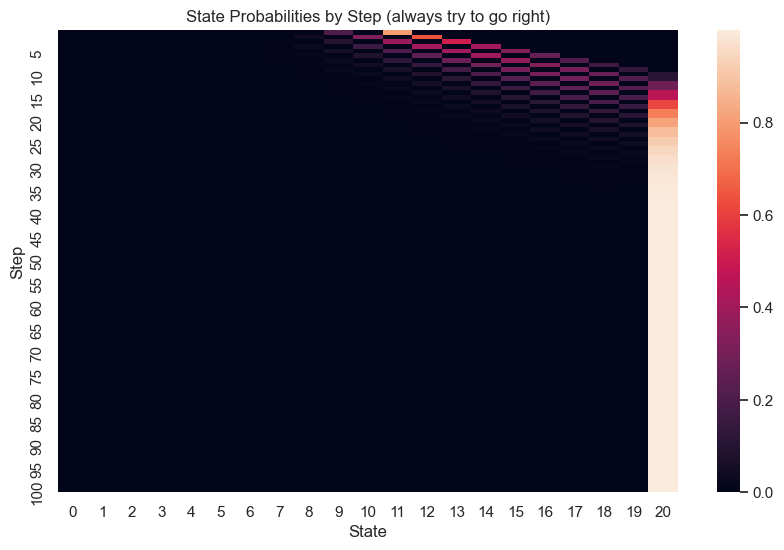

In [260]:
mtx = sns.heatmap(df, annot = False)
mtx.set(xlabel = 'State',
        ylabel = 'Step',
        yticks = list(range(5, 105, 5)),
        yticklabels = list(range(5, 105, 5)),
        title = 'State Probabilities by Step (always try to go right)',);

#### Report the likelihood of each transition from our simulation (using the likelihood of the first 100 steps as computed above)

This code block creates a new dataframe for the steps and observations from our simulation. It then uses the table above to look up the likelihood of each transition at its associated time/step.

In [261]:
likelihood_df = pd.DataFrame({'t': t_log[1:], 'observation': observations[1:]}) # we can leave out the first observation since it will always be 10
likelihood_df['likelihood'] = ''

for index, row in likelihood_df.iterrows():
    # go look up the relevant values from the likelihood table that we created above (df)
    likelihood_df.loc[index, 'likelihood'] = df.iloc[likelihood_df.loc[index, 't']-1, likelihood_df.loc[index, 'observation']]

likelihood_df

,t,observation,likelihood
0,1,11,0.8
1,2,10,0.32
2,3,11,0.384
3,4,10,0.1536
4,5,9,0.0512
5,6,10,0.08192
6,7,9,0.028672
7,8,10,0.045875
8,9,9,0.016515
9,10,8,0.005505


#  ------------- Homework 1 Archive Below -------------------------- 

#### Write a policy -- always move to the right

In [3]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [4]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

p = 0.8, meaning that the robot's action will result in moving right 80% of the time, and left the other 20% of the time

In [5]:
env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [6]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [7]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,1.0,2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,2.0,3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,3.0,4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,4.0,5.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,5.0,6.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,6.0,7.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,7.0,8.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,8.0,7.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,7.0,8.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [8]:
v0 = np.sum(dta['beta^t_reward'])
v0

0.30255972762428573

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [9]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.8,terminal=10,done=False)
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [10]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,1.0,2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,2.0,3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,3.0,4.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,4.0,5.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
16253,999.0,21.0,7.0,6.0,1.0,-0.05,0.98,0.654256,-0.032713
16254,999.0,22.0,6.0,7.0,1.0,-0.05,0.98,0.641171,-0.032059
16255,999.0,23.0,7.0,8.0,1.0,-0.05,0.98,0.628347,-0.031417
16256,999.0,24.0,8.0,9.0,1.0,-0.05,0.98,0.615780,-0.030789


#### Group by episode to sum the discounted realized rewards for each episode

In [11]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,0.418117
1.0,0.302560
2.0,0.191578
3.0,-0.210105
4.0,0.302560
...,...
995.0,0.302560
996.0,0.418117
997.0,-0.387873


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [12]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,0.084702
std,0.251886
min,-0.842579
1%,-0.628989
5%,-0.387873
10%,-0.300785
25%,-0.017374
50%,0.084992
75%,0.302560


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

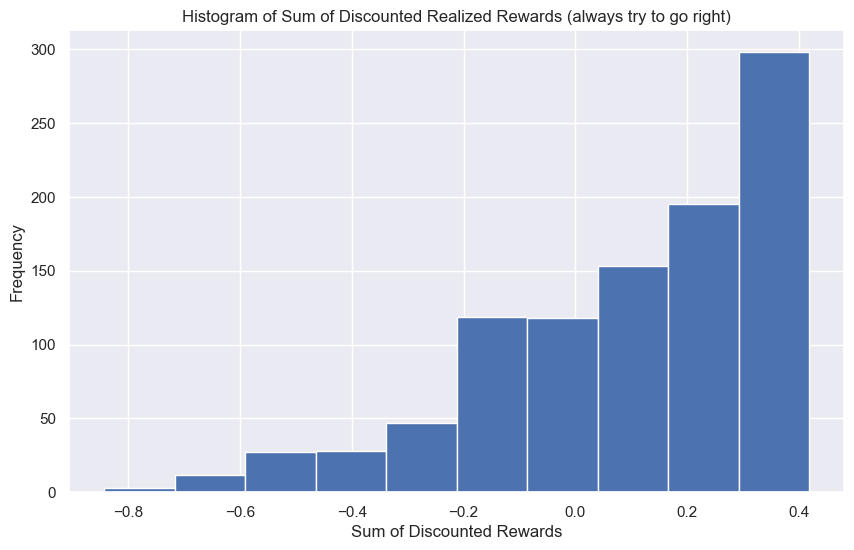

In [13]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards (always try to go right)')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [14]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.8,terminal=10,done=False)
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [15]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
1,-9.0,0.0,1.0,-8.0,-7.0,1.0,-0.05,0.98,0.980000,-0.049000
2,-9.0,0.0,2.0,-7.0,-6.0,1.0,-0.05,0.98,0.960400,-0.048020
3,-9.0,0.0,3.0,-6.0,-7.0,1.0,-0.05,0.98,0.941192,-0.047060
4,-9.0,0.0,4.0,-7.0,-6.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...,...
304255,9.0,995.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
304256,9.0,996.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
304257,9.0,997.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000
304258,9.0,998.0,0.0,9.0,10.0,1.0,1.00,0.98,1.000000,1.000000


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [16]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-0.6918,0.3249,-1.5896,-1.5896,-1.1164,-1.0076,-1.0000,-0.6664,-0.4301,-0.2559,-0.1634,-0.0670,-0.0670
-8.0,1000.0,-0.5525,0.2989,-1.5896,-1.5896,-1.0882,-1.0300,-0.7031,-0.4715,-0.3008,-0.2101,-0.1157,-0.0174,-0.0174
-7.0,1000.0,-0.4626,0.2860,-1.5896,-1.1734,-1.0018,-0.8757,-0.5908,-0.4301,-0.2559,-0.1634,-0.0670,0.0333,0.0333
-6.0,1000.0,-0.3885,0.2575,-1.5896,-1.0899,-0.8426,-0.7742,-0.5518,-0.3879,-0.2101,-0.1157,-0.0174,0.0850,0.0850
-5.0,1000.0,-0.3111,0.2746,-1.5896,-1.0612,-0.8088,-0.6664,-0.5121,-0.2559,-0.0670,0.0333,0.0333,0.1377,0.1377
-4.0,1000.0,-0.2547,0.2895,-1.5896,-1.0318,-0.8426,-0.7031,-0.3879,-0.2101,-0.0174,0.0850,0.0850,0.1916,0.1916
-3.0,1000.0,-0.1850,0.2744,-1.5896,-0.9400,-0.6664,-0.5908,-0.3448,-0.1634,0.0333,0.1377,0.2465,0.2465,0.2465
-2.0,1000.0,-0.0928,0.2613,-1.5896,-0.8426,-0.5518,-0.4715,-0.2101,-0.0174,0.0850,0.1916,0.3026,0.3026,0.3026
-1.0,1000.0,-0.0139,0.2690,-1.5896,-0.7390,-0.5121,-0.3448,-0.1634,0.0333,0.1377,0.2465,0.3598,0.3598,0.3598


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

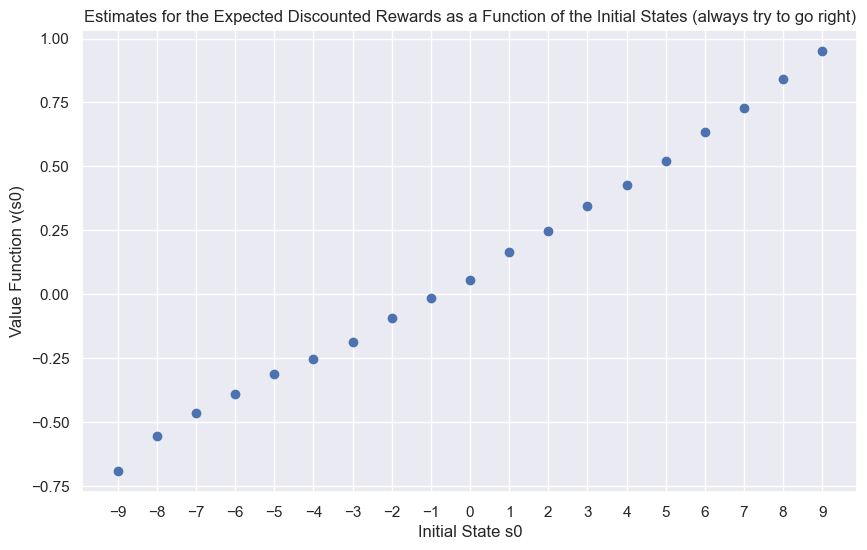

In [17]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States (always try to go right)')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either terminal of the path (-10 or 10), the episode ends and the robot doesn't make any more moves. For every other space, the robot has an 80% chance of moving right, and a 20% chance of moving left.

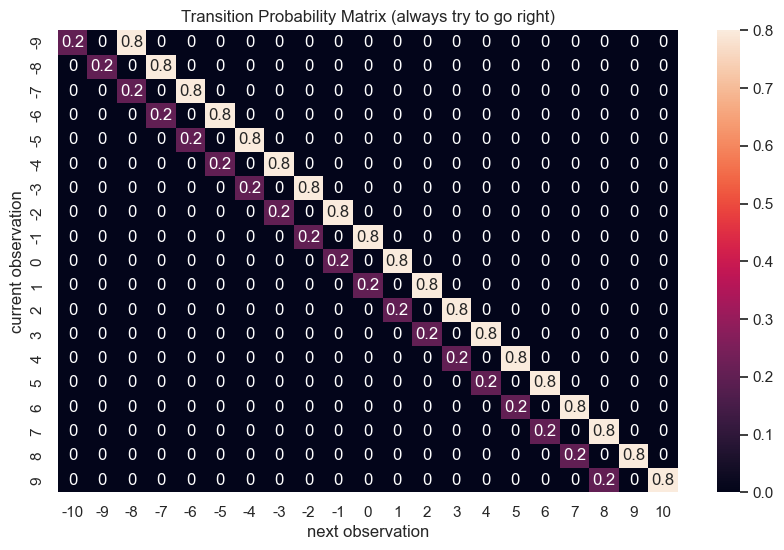

In [18]:
P = np.zeros((19, 21))
P = pd.DataFrame(P)

for s in list(range(19)):
    P.iloc[s, s+2] = 0.8 # 80% chance of moving right as intended
    P.iloc[s, s] = 0.2 # 20% chance of moving left

P.columns = list(range(-10, 11))
P.index = list(range(-9, 10))

sns.set(rc = {"figure.figsize":(10, 6)})
mtx = sns.heatmap(P, annot = True)
mtx.set(xlabel = 'next observation', ylabel = 'current observation', title = 'Transition Probability Matrix (always try to go right)');

### Question 2 -- Always try to go Left

#### Write a policy -- always move to the left

Keep the "policy" the same, but change the episode probability below to 0.2, which is effectively the same as saying that the robot will try to go left with an 80% success rate, but will end up going right 20% of the time.

In [19]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [20]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

To account for the updated policy (try to go left with 80% success, go right the other 20%), change the value of p.

In [21]:
env = Segment(numActions=2,startObservation=10,p=0.2,terminal=10,done=False) # change p = 0.2
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [22]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [23]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,-1.0,-2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,-2.0,-3.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,-3.0,-2.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,-2.0,-3.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,-3.0,-2.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,-2.0,-1.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,-1.0,0.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,0.0,1.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,1.0,0.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [24]:
v0 = np.sum(dta['beta^t_reward'])
v0

-1.698138050507817

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [25]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.2,terminal=10,done=False) # change p = 0.2
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [26]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,1.0,0.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,0.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,-1.0,-2.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,-2.0,-1.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
16923,999.0,7.0,-7.0,-8.0,1.0,-0.05,0.98,0.868126,-0.043406
16924,999.0,8.0,-8.0,-7.0,1.0,-0.05,0.98,0.850763,-0.042538
16925,999.0,9.0,-7.0,-8.0,1.0,-0.05,0.98,0.833748,-0.041687
16926,999.0,10.0,-8.0,-9.0,1.0,-0.05,0.98,0.817073,-0.040854


#### Group by episode to sum the discounted realized rewards for each episode

In [27]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,-1.392146
1.0,-1.478151
2.0,-1.298903
3.0,-1.392146
4.0,-1.392146
...,...
995.0,-1.436017
996.0,-1.665075
997.0,-1.557479


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [28]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,-1.405949
std,0.112665
min,-1.895683
1%,-1.729892
5%,-1.630649
10%,-1.557479
25%,-1.478151
50%,-1.392146
75%,-1.298903


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

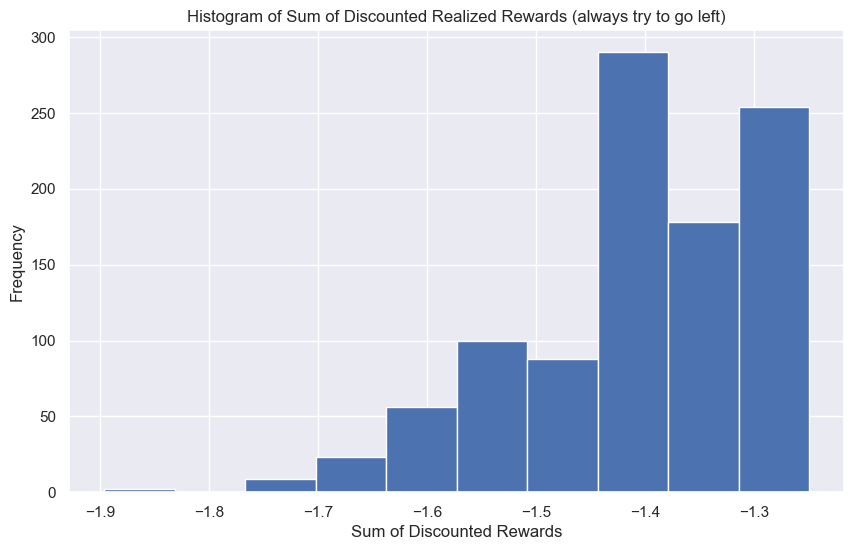

In [29]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards (always try to go left)')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [30]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.2,terminal=10,done=False) # change p = 0.2
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [31]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
1,-9.0,1.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
2,-9.0,2.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
3,-9.0,3.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
4,-9.0,4.0,0.0,-9.0,-10.0,1.0,-1.00,0.98,1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...
305270,9.0,999.0,45.0,-6.0,-7.0,1.0,-0.05,0.98,0.402878,-0.020144
305271,9.0,999.0,46.0,-7.0,-6.0,1.0,-0.05,0.98,0.394820,-0.019741
305272,9.0,999.0,47.0,-6.0,-7.0,1.0,-0.05,0.98,0.386924,-0.019346
305273,9.0,999.0,48.0,-7.0,-8.0,1.0,-0.05,0.98,0.379185,-0.018959


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [32]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-1.0183,0.0431,-1.3229,-1.2239,-1.1164,-1.0594,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
-8.0,1000.0,-1.0672,0.0644,-1.4782,-1.3465,-1.1978,-1.1441,-1.0882,-1.0300,-1.0300,-1.0300,-1.0300,-1.0300,-1.0300
-7.0,1000.0,-1.1151,0.0815,-1.8039,-1.4143,-1.2744,-1.2239,-1.1164,-1.0594,-1.0594,-1.0594,-1.0594,-1.0594,-1.0594
-6.0,1000.0,-1.1558,0.0821,-1.5186,-1.4360,-1.3013,-1.2494,-1.1978,-1.1441,-1.0882,-1.0882,-1.0882,-1.0882,-1.0882
-5.0,1000.0,-1.2069,0.0951,-1.6129,-1.5382,-1.4143,-1.3229,-1.2744,-1.1712,-1.1164,-1.1164,-1.1164,-1.1164,-1.1164
-4.0,1000.0,-1.2446,0.1007,-1.7604,-1.5948,-1.4360,-1.3921,-1.2989,-1.1978,-1.1441,-1.1441,-1.1441,-1.1441,-1.1441
-3.0,1000.0,-1.2844,0.0990,-1.6818,-1.5763,-1.4573,-1.4143,-1.3229,-1.2744,-1.2239,-1.1712,-1.1712,-1.1712,-1.1712
-2.0,1000.0,-1.3204,0.1048,-1.7604,-1.6306,-1.5186,-1.4782,-1.3921,-1.2989,-1.2494,-1.1978,-1.1978,-1.1978,-1.1978
-1.0,1000.0,-1.3684,0.1128,-1.9078,-1.6818,-1.5763,-1.5382,-1.4143,-1.3695,-1.2744,-1.2239,-1.2239,-1.2239,-1.2239


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

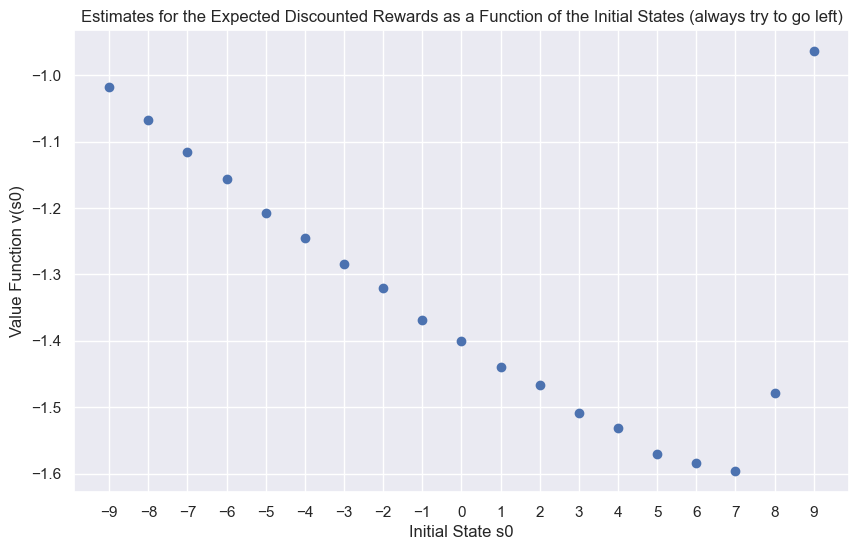

In [33]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States (always try to go left)')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either terminal of the path (-10 or 10), the episode ends and the robot doesn't make any more moves. For every other space, the robot has an 80% chance of moving left, and a 20% chance of moving right.

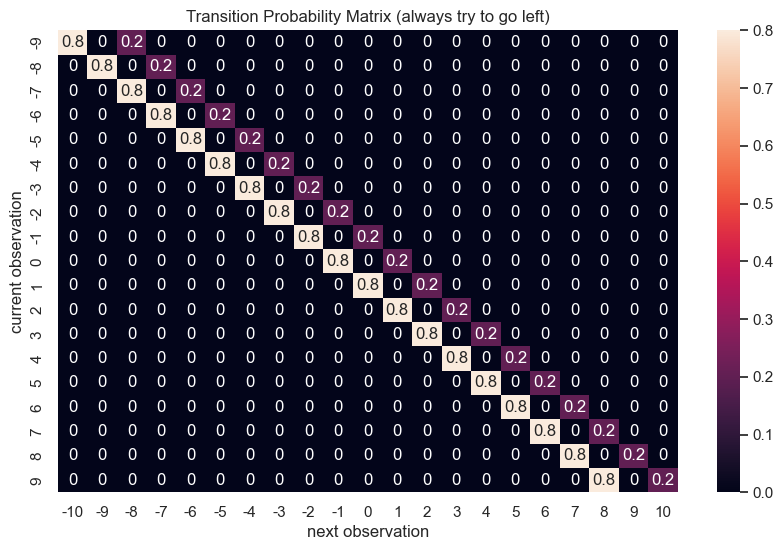

In [34]:
P = np.zeros((19, 21))
P = pd.DataFrame(P)

for s in list(range(19)):
    P.iloc[s, s+2] = 0.2 # 20% chance of moving right
    P.iloc[s, s] = 0.8 # 80% chance of moving left as intended

P.columns = list(range(-10, 11))
P.index = list(range(-9, 10))

sns.set(rc = {"figure.figsize":(10, 6)})
mtx = sns.heatmap(P, annot = True)
mtx.set(xlabel = 'next observation', ylabel = 'current observation', title = 'Transition Probability Matrix (always try to go left)');

### Question 3 -- 50/50 Left vs Right

#### Write a policy -- go right 50% of the time, left 50% of the time

Same as in Question 2, keep the "policy" itself as is but change the episode probabilities to reflect the 50/50 change.

In [35]:
def policy(observation):
    action = 1
    return action

#### Initiate values and create empty lists

In [36]:
t=0
tMAX = 50
done = False
observation = 10
observations = [observation]
rewards = []
actions = []

#### Construct a loop to go through an episode

To account for the updated policy (try to go left 50% of the time, right 50% of the time), change the value of p.

In [37]:
env = Segment(numActions=2,startObservation=10,p=0.5,terminal=10,done=False) # change p = 0.5
while t <tMAX and done==False:
    action = policy(observation=observation)
    observation_next,reward,done = env.step(action=action)
    observations.append(observation_next)
    rewards.append(reward)
    actions.append(action)
    observation = observation_next
    t+=1

#### Collect the transition states, actions and rewards. Compute the present discounted value of the rewards received at each transition. Assume discount factor of beta = 0.98.

In [38]:
dta = pd.DataFrame(
             [range(0,t),
              observations[0:t],
              observations[1:(t+1)],
              actions[0:t],
              rewards]).transpose()

dta.columns = ['t','observation','observation_next','action','reward']
dta['observation'] = dta['observation'] - 10
dta['observation_next'] = dta['observation_next'] - 10
dta['beta'] = 0.98
dta['beta^t'] = dta['beta']**dta['t']
dta['beta^t_reward'] = dta['beta^t']*dta['reward']

#### Recreate Table 2.1

This table presents the transitions, actions, realized rewards, and realized discounted rewards during one episode.

In [39]:
dta

,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,1.0,1.0,0.0,1.0,-0.05,0.98,0.980000,-0.049000
2,2.0,0.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,3.0,-1.0,-2.0,1.0,-0.05,0.98,0.941192,-0.047060
4,4.0,-2.0,-3.0,1.0,-0.05,0.98,0.922368,-0.046118
5,5.0,-3.0,-4.0,1.0,-0.05,0.98,0.903921,-0.045196
6,6.0,-4.0,-3.0,1.0,-0.05,0.98,0.885842,-0.044292
7,7.0,-3.0,-2.0,1.0,-0.05,0.98,0.868126,-0.043406
8,8.0,-2.0,-1.0,1.0,-0.05,0.98,0.850763,-0.042538
9,9.0,-1.0,0.0,1.0,-0.05,0.98,0.833748,-0.041687


#### Compute the sum of the discounted rewards realized during the episode

In [40]:
v0 = np.sum(dta['beta^t_reward'])
v0

-1.5895757997822069

#### Estimating  v(s0) 

(aka, the expected discounted rewards at the initial state)

In [41]:
%%capture

allEpisodes = pd.DataFrame()
for e in range(0,1000):
    t=0
    tMAX = 50
    done = False
    observation = 10
    observations = [observation]
    rewards = []
    actions = []
    env = Segment(numActions=2,startObservation=10,p=0.5,terminal=10,done=False) # change p = 0.5
    while t <tMAX and done==False:
        action = policy(observation=observation)
        observation_next,reward,done = env.step(action=action)
        observations.append(observation_next)
        rewards.append(reward)
        actions.append(action)
        observation = observation_next
        t+=1
    dta = pd.DataFrame(
                 [[e]*t,
                  range(0,t),
                  observations[0:t],
                  observations[1:(t+1)],
                  actions[0:t],
                  rewards]).transpose()
    dta.columns = ['episode','t','observation','observation_next','action','reward']
    dta['observation'] = dta['observation'] - 10
    dta['observation_next'] = dta['observation_next'] - 10
    dta['beta'] = 0.98
    dta['beta^t'] = dta['beta']**dta['t']
    dta['beta^t_reward'] = dta['beta^t']*dta['reward']
    allEpisodes = allEpisodes.append(dta,ignore_index=True)

In [42]:
allEpisodes

,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,0.0,0.0,0.0,-1.0,1.0,-0.05,0.98,1.000000,-0.050000
1,0.0,1.0,-1.0,-2.0,1.0,-0.05,0.98,0.980000,-0.049000
2,0.0,2.0,-2.0,-1.0,1.0,-0.05,0.98,0.960400,-0.048020
3,0.0,3.0,-1.0,0.0,1.0,-0.05,0.98,0.941192,-0.047060
4,0.0,4.0,0.0,-1.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...
44751,999.0,45.0,1.0,0.0,1.0,-0.05,0.98,0.402878,-0.020144
44752,999.0,46.0,0.0,-1.0,1.0,-0.05,0.98,0.394820,-0.019741
44753,999.0,47.0,-1.0,0.0,1.0,-0.05,0.98,0.386924,-0.019346
44754,999.0,48.0,0.0,1.0,1.0,-0.05,0.98,0.379185,-0.018959


#### Group by episode to sum the discounted realized rewards for each episode

In [43]:
sum_by_episode = pd.DataFrame(allEpisodes.groupby('episode')['beta^t_reward'].sum())
sum_by_episode

,beta^t_reward
episode,
0.0,-1.589576
1.0,-1.589576
2.0,-1.589576
3.0,-1.589576
4.0,-1.031786
...,...
995.0,-1.589576
996.0,-1.589576
997.0,-1.589576


#### Recreate Table 2.4

This table presents summary statistics of the sum of discounted realized rewards across all episodes. The mean value represents the estimate for  
E0[~v(s0)].

In [44]:
sum_by_episode.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,beta^t_reward
count,1000.000000
mean,-1.447666
std,0.404014
min,-1.942597
1%,-1.919844
5%,-1.760388
10%,-1.589576
25%,-1.589576
50%,-1.589576
75%,-1.589576


#### Recreate Figure 2.2

This histogram shows the sum of the discounted realized rewards across all episodes

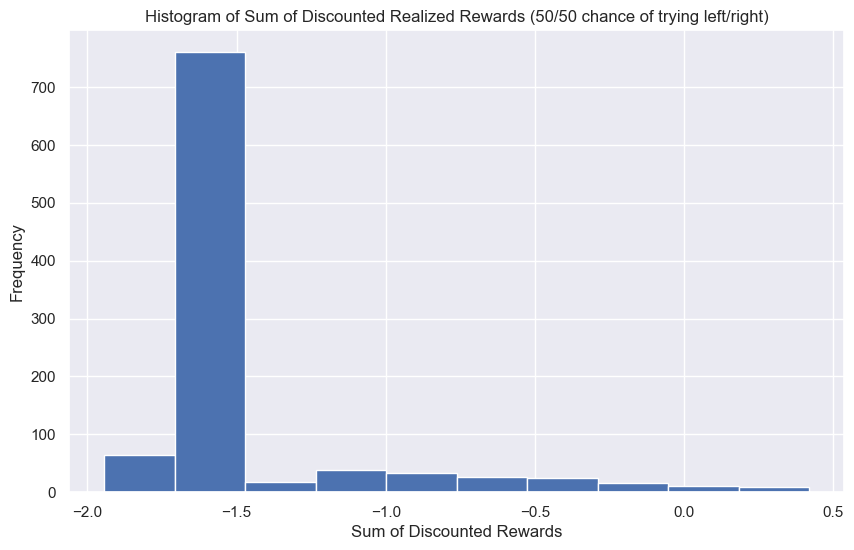

In [45]:
plt.figure(figsize = (10,6))
plt.hist(sum_by_episode)
plt.title('Histogram of Sum of Discounted Realized Rewards (50/50 chance of trying left/right)')
plt.xlabel('Sum of Discounted Rewards')
plt.ylabel('Frequency')
plt.show()

#### Estimate v for every initial state

Compute the expected value of the discounted rewards at every possible initial state (segment position) in the path. Create a loop to iterate over several episodes for each initial state.

In [46]:
%%capture

allEpisodes = pd.DataFrame()
obs = range(1,20)
for o in obs:
    for e in range(0,1000):
        t=0
        tMAX = 50
        done = False
        observation = np.int(o)
        observations = [observation]
        rewards = []
        actions = []
        env = Segment(numActions=2,startObservation=observation,p=0.5,terminal=10,done=False) # change p = 0.5
        while t <tMAX and done==False:
            action = policy(observation=observation)
            observation_next,reward,done = env.step(action=action)
            observations.append(observation_next)
            rewards.append(reward)
            actions.append(action)
            observation = observation_next
            t+=1
        dta = pd.DataFrame(
                    [[o-10]*t,
                    [e]*t,
                    range(0,t),
                    observations[0:t],
                    observations[1:(t+1)],
                    actions[0:t],
                    rewards]).transpose()
        dta.columns = ['initial','episode','t','observation','observation_next','action','reward']
        dta['observation'] = dta['observation'] - 10
        dta['observation_next'] = dta['observation_next'] - 10
        dta['beta'] = 0.98
        dta['beta^t'] = dta['beta']**dta['t']
        dta['beta^t_reward'] = dta['beta^t']*dta['reward']
        allEpisodes = allEpisodes.append(dta,ignore_index=True)

#### Show the discounted realized rewards for each step for a sample of episodes and initial states

In [47]:
allEpisodes

,initial,episode,t,observation,observation_next,action,reward,beta,beta^t,beta^t_reward
0,-9.0,0.0,0.0,-9.0,-8.0,1.0,-0.05,0.98,1.000000,-0.050000
1,-9.0,0.0,1.0,-8.0,-7.0,1.0,-0.05,0.98,0.980000,-0.049000
2,-9.0,0.0,2.0,-7.0,-6.0,1.0,-0.05,0.98,0.960400,-0.048020
3,-9.0,0.0,3.0,-6.0,-7.0,1.0,-0.05,0.98,0.941192,-0.047060
4,-9.0,0.0,4.0,-7.0,-8.0,1.0,-0.05,0.98,0.922368,-0.046118
...,...,...,...,...,...,...,...,...,...,...
621962,9.0,999.0,20.0,7.0,8.0,1.0,-0.05,0.98,0.667608,-0.033380
621963,9.0,999.0,21.0,8.0,7.0,1.0,-0.05,0.98,0.654256,-0.032713
621964,9.0,999.0,22.0,7.0,8.0,1.0,-0.05,0.98,0.641171,-0.032059
621965,9.0,999.0,23.0,8.0,9.0,1.0,-0.05,0.98,0.628347,-0.031417


#### Recreate Table 2.6

Summary statistics of the sum of discounted realized rewards across all episodes for each initial state.

In [48]:
v0_matrix = allEpisodes.groupby(['initial', 'episode'], as_index = False)['beta^t_reward'].sum().pivot('initial', 'episode').fillna(0)
v0_summary = v0_matrix.apply(lambda x: x.describe(percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(4), axis = 1)
v0_summary

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
initial,,,,,,,,,,,,,,
-9.0,1000.0,-1.1704,0.2431,-1.9312,-1.8834,-1.5896,-1.5896,-1.2744,-1.0594,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000
-8.0,1000.0,-1.3039,0.2592,-1.9426,-1.8957,-1.7299,-1.5896,-1.5896,-1.1978,-1.0882,-1.0300,-1.0300,-1.0300,-0.7742
-7.0,1000.0,-1.3946,0.2465,-1.9312,-1.9078,-1.7752,-1.6129,-1.5896,-1.4573,-1.1712,-1.0594,-1.0594,-1.0594,-0.4301
-6.0,1000.0,-1.4723,0.2284,-1.9426,-1.9196,-1.8178,-1.6981,-1.5896,-1.5896,-1.2989,-1.1441,-1.0882,-0.9706,-0.2101
-5.0,1000.0,-1.5040,0.2160,-1.9312,-1.9312,-1.8039,-1.6818,-1.5896,-1.5896,-1.4143,-1.1712,-1.1164,-0.6664,-0.1634
-4.0,1000.0,-1.5233,0.2318,-1.9426,-1.9196,-1.8448,-1.7299,-1.5896,-1.5896,-1.4782,-1.1978,-1.1441,-0.6282,-0.2101
-3.0,1000.0,-1.5267,0.2538,-1.9312,-1.9312,-1.8328,-1.7142,-1.5896,-1.5896,-1.5896,-1.2744,-1.0018,-0.5113,-0.0670
-2.0,1000.0,-1.4988,0.3173,-1.9426,-1.9426,-1.8178,-1.6651,-1.5896,-1.5896,-1.5896,-1.1458,-0.7031,-0.2101,0.3026
-1.0,1000.0,-1.4958,0.3344,-1.9312,-1.9080,-1.8314,-1.6818,-1.5896,-1.5896,-1.5896,-1.0612,-0.7390,-0.0670,0.3598


#### Recreate Figure 2.3

Presents the estimates for the expected discounted rewards as a function of the initial states.

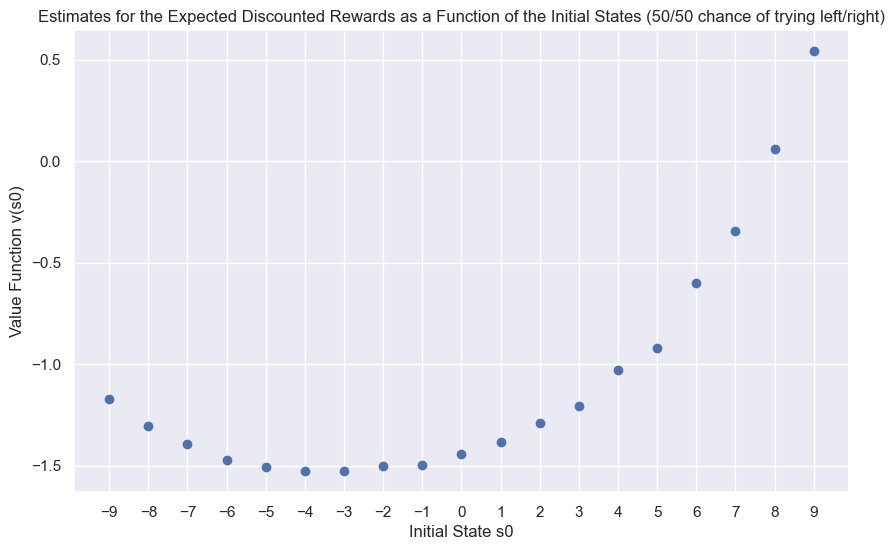

In [49]:
plt.figure(figsize = (10,6))
plt.scatter(v0_summary.index, v0_summary['mean'])
plt.xticks(v0_summary.index)
plt.title('Estimates for the Expected Discounted Rewards as a Function of the Initial States (50/50 chance of trying left/right)')
plt.xlabel('Initial State s0')
plt.ylabel('Value Function v(s0)')
plt.show()

#### Create a Transition Probability Matrix

In the matrix below, each element represents the probability of transitioning from state i (row value) to state j (column value). We know from the problem setup that if the robot is at either terminal of the path (-10 or 10), the episode ends and the robot doesn't make any more moves. For every other space, the robot has a 50% chance of moving right, and a 50% chance of moving left.

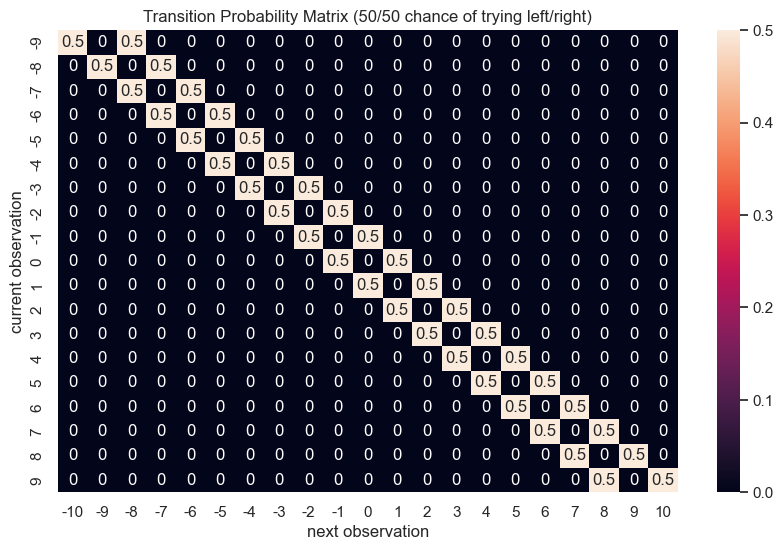

In [50]:
P = np.zeros((19, 21))
P = pd.DataFrame(P)

for s in list(range(19)):
    P.iloc[s, s+2] = 0.5 # 50% chance of moving right
    P.iloc[s, s] = 0.5 # 50% chance of moving left

P.columns = list(range(-10, 11))
P.index = list(range(-9, 10))

sns.set(rc = {"figure.figsize":(10, 6)})
mtx = sns.heatmap(P, annot = True)
mtx.set(xlabel = 'next observation', ylabel = 'current observation', title = 'Transition Probability Matrix (50/50 chance of trying left/right)');